In [ ]:
''' 
Purpose of this notebook is to experiment with lidar data and begin to play arround 
with time series analysis.

Input: Lidar data from oregon
'''

In [1]:
import pdal
import glob
import io
import ipyleaflet
import IPython.display
import ipyvolume.pylab as p3
import matplotlib.cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely.geometry
import scipy.spatial
import pyproj

import os
import requests
import json
import sys
import urllib.request


In [2]:
m = ipyleaflet.Map(center=(45.688698,-121.760025), zoom=13)
m

Map(center=[45.688698, -121.760025], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

In [3]:
dc = ipyleaflet.DrawControl()
m.add_control(dc)

In [24]:
dc.last_draw['geometry']#['coordinates']

{'type': 'Point', 'coordinates': [-121.743104, 45.686535]}

POLYGON ((1682932.047131753 739248.3801158334, 1683803.136131753 739248.3801158334, 1683803.136131753 740037.4101158334, 1682932.047131753 740037.4101158334, 1682932.047131753 739248.3801158334))


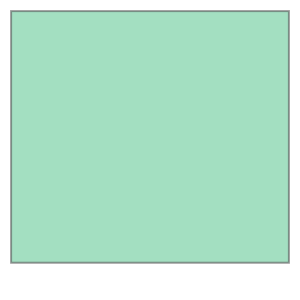

In [6]:
wsg84 = pyproj.Proj('epsg:4326')
lambert = pyproj.Proj('epsg:32026')
#coords = [pyproj.transform(wsg84,lambert,x,y) for (x,y) in dc.last_draw['geometry']['coordinates'][0]]
#polygon = shapely.geometry.Polygon(coords)
#print(polygon.wkt)
#IPython.display.display(polygon)
#coords
#but = shapely.geometry.Polygon[(1682932.047131752828136, 739248.38011583336629], [1683803.136131752748042,739248.38011583336629 ], [1683803.136131752748042,740037.410115833394229], [1682932.047131752828136,740037.410115833394229], [1682932.047131752828136,739248.38011583336629)]

#oregon
coords = [(1682932.047131752828136, 739248.38011583336629), (1683803.136131752748042,739248.38011583336629), (1683803.136131752748042,740037.410115833394229), (1682932.047131752828136,740037.410115833394229), (1682932.047131752828136,739248.38011583336629)]
polygon = shapely.geometry.Polygon(coords)
#polygon



#coords = [(-121.742387772078075, 45.687139928911662), (-121.739387772078075, 45.687139928911662), (-121.739387772078075,45.690139928911663), (-121.742387772078075, 45.690139928911663), (-121.742387772078075, 45.687139928911662)]
#polygon = shapely.geometry.Polygon(coords)
print(polygon.wkt)
IPython.display.display(polygon)



In [186]:
jr_las = '/home/jose/Desktop/LiDAR_oregon/JR05_2018/points.las'
jr_las2 = '/home/jose/Github/my_projs/abm_detect/notebooks/JR_crop.bpf'

In [55]:
point = shapely.geometry.Point(dc.last_draw['geometry']['coordinates'])
point = shapely.geometry.Point([-121.744288317259716, 45.685326471026336])

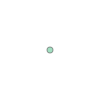

In [56]:
point

In [222]:
# carefull!!! WILL write a file!

b = polygon.bounds
cropper = {
    "pipeline": [ jr_las,
   
        {   "type":"filters.crop",
             "a_srs": "EPSG:4326",
             "point":point.wkt,
             "distance": 500
        },
        
        {
            "type": "filters.range",
            "limits":"Classification[:8]",
        },
        
        {   "type":"filters.eigenvalues",
            "knn":16},
        {   "type":"filters.normal",
            "knn":16},
        {   "type":"filters.hag_nn"},
        
        {   "type": "writers.bpf",
             "filename": "./JR_crop.bpf"
            
        }
    ]}
pipeline = pdal.Pipeline(json.dumps(cropper))
pipeline.validate()
%time n_points = pipeline.execute()
print('Pipeline selected {} points ({:.1f} pts/m2)'.format(n_points, n_points))

CPU times: user 1.75 s, sys: 24 ms, total: 1.77 s
Wall time: 1.78 s
Pipeline selected 1787152 points (1787152.0 pts/m2)


In [187]:
cropper = {
    "pipeline": [ jr_las2,
  
        
        {
            "type": "filters.range",
            "limits":"Classification[:8]",
        },
                 
                 
        
    ]}

pipeline = pdal.Pipeline(json.dumps(cropper))
pipeline.validate()
%time n_points = pipeline.execute()
print('Pipeline selected {} points ({:.1f} pts/m2)'.format(n_points, n_points))

CPU times: user 322 ms, sys: 4.02 ms, total: 326 ms
Wall time: 323 ms
Pipeline selected 210188 points (210188.0 pts/m2)


Pipeline selected 0 points (0.0 pts/m2)


In [ ]:
# DOES NOT WORK!!!! 
# Still needs to work with a polygon instead of a point!

bounds = polygon.bounds
cropper = {
    "pipeline": [
        
    {
            "type": "readers.las",
            "spatialreference": "EPSG:4326",
            "filename": jr_las
        },
        
        {
            "type": "filters.range",
            "limits":"Classification[:8]",
        },
        
        {   "type":"filters.reprojection",
            "in_srs":"EPSG:4326",
            "out_srs":"EPSG:32026"
        },
        
      
        {   "type":"filters.crop",
            "a_srs": "EPSG:32026",
            "polygon": polygon.wkt,
            "outside": "false"
        },
        

    ]}



pipeline = pdal.Pipeline(json.dumps(cropper))
pipeline.validate()
n_points = pipeline.execute()
print('Pipeline selected {} points ({:.1f} pts/m2)'.format(n_points, n_points/polygon.area))

In [203]:
#creating numpy and pandas objects from pdal pipeline
arr = pipeline.arrays[0]
description = arr.dtype.descr
cols = [col for col, __ in description]
df = pd.DataFrame({col: arr[col] for col in cols})
df['X_0'] = df['X']
df['Y_0'] = df['Y']
df['Z_0'] = df['Z']
df['X'] = df['X'] - df['X_0'].min()
df['Y'] = df['Y'] - df['Y_0'].min()
df['Z'] = df['Z'] - df['Z_0'].min()

In [212]:
fig = p3.figure(width=500)
fig.xlabel='Y'
fig.ylabel='Z'
fig.zlabel='X'
all_points = p3.scatter(df['Y'], df['Z'], df['X'], color='red', size=.2,marker='arrow')
p3.squarelim()
p3.show()

In [201]:
df

,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,ScanAngleRank,...,Eigenvalue1,Eigenvalue2,NormalX,NormalY,NormalZ,Curvature,HeightAboveGround,X_0,Y_0,Z_0
0,0.04,97.59,213.39,42335,3,3,0,0,1,-38.0,...,0.214535,1.087465,-0.574958,-0.186935,0.796542,0.005641,0.10,597783.23,5059950.17,339.26
1,0.19,96.84,213.24,34908,3,3,0,0,2,-38.0,...,0.209688,0.995877,-0.560994,-0.191357,0.805400,0.006073,0.00,597783.38,5059949.42,339.11
2,0.45,95.53,213.19,30866,3,3,0,1,1,-38.0,...,0.283765,1.318074,-0.486064,-0.207732,0.848876,0.007737,0.23,597783.64,5059948.11,339.06
3,0.01,97.74,213.29,46114,1,1,0,0,2,-38.0,...,0.214535,1.087465,-0.574958,-0.186935,0.796542,0.005641,0.00,597783.20,5059950.32,339.16
4,0.31,96.28,213.06,43821,2,2,0,0,2,-38.0,...,0.308808,0.871104,-0.538986,-0.190409,0.820511,0.006339,0.00,597783.50,5059948.86,338.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2579449,402.34,277.34,268.50,29883,2,3,0,0,4,-37.0,...,0.861714,1.380097,0.562877,0.439974,0.699709,0.148015,17.47,598185.53,5060129.92,394.37
2579450,400.46,280.15,264.03,39080,3,3,0,0,1,-37.0,...,2.138185,2.949949,-0.777974,0.618078,0.112850,0.100421,13.99,598183.65,5060132.73,389.90
2579451,400.47,280.17,265.16,38709,3,4,0,0,4,-37.0,...,1.264667,3.434836,-0.868747,0.483919,0.105360,0.130579,15.12,598183.66,5060132.75,391.03
2579452,388.51,298.05,236.78,31566,4,4,0,0,2,-37.0,...,0.171169,0.224611,0.250431,0.645692,0.721364,0.003802,0.00,598171.70,5060150.63,362.65


In [213]:
# Color ground in grey
df['ground'] = df['Classification']!=1
ground = p3.scatter(df.loc[df['ground'],'Y'].values, df.loc[df['ground'],'Z'].values, df.loc[df['ground'],'X'].values, color='red', size=.2,marker='arrow')
non_ground = p3.scatter(df.loc[~df['ground'],'Y'].values, df.loc[~df['ground'],'Z'].values, df.loc[~df['ground'],'X'].values, color='red', size=.2)
fig.scatters.append(ground)
fig.scatters.append(non_ground)
all_points.visible = False
ground.color='lightgrey'

In [214]:
# Show ground as surface
ground_delaunay = scipy.spatial.Delaunay(df.loc[df['ground'],['X','Y']])
ground_surf = p3.plot_trisurf(df.loc[df['ground'],'Y'], df.loc[df['ground'],'Z'], df.loc[df['ground'],'X'], ground_delaunay.simplices, color='lightgrey')
fig.meshes.append(ground_surf)
ground.visible=False

In [216]:
# Color points according to flatness
df['flatness'] = df['Eigenvalue0'] 
non_ground.color=matplotlib.cm.viridis(df.loc[~df['ground'],'flatness']*4)[:,0:3]

In [217]:
# Separate between trees and the rest
df['tree_potential'] = (df['Classification']==1) & (df['HeightAboveGround'] >= 2) & (df['flatness'] > .05) &  (df['NumberOfReturns'] - df['ReturnNumber'] >= 1) 
df['other'] = ~df['ground'] & ~df['tree_potential']
tree_potential = p3.scatter(df.loc[df['tree_potential'],'Y'].values, df.loc[df['tree_potential'],'Z'].values, df.loc[df['tree_potential'],'X'].values, color=matplotlib.cm.viridis(df.loc[df['tree_potential'],'flatness']*4)[:,0:3], size=.2)
other = p3.scatter(df.loc[df['other'],'Y'].values, df.loc[df['other'],'Z'].values, df.loc[df['other'],'X'].values, color=matplotlib.cm.viridis(df.loc[df['other'],'flatness']*4)[:,0:3], size=.2)
non_ground.visible=False
tree_potential.color='darkgreen'
other.color='red'

In [218]:
#Hide non-tree
other.visible=False

In [95]:
lep = local_max(df.loc[df['tree_potential'],['X','Y','Z','HeightAboveGround']], radius=3, density_threshold=15)

NameError: name 'local_max' is not defined

In [ ]:
coords=dc.last_draw['geometry']['coordinates'][0]

In [ ]:
polygon = shapely.geometry.Polygon(coords)
print(polygon.wkt)

bounds = polygon.bounds

In [ ]:
b = polygon.bounds

In [ ]:
pipeline.validate()

In [ ]:
polygon.wkt


In [ ]:
df

In [ ]:
pipeline.validate()

In [ ]:
polygon.wkt

In [ ]:
b

In [ ]:
cd 

In [ ]:
cd Desktop/LiDAR_oregon/JR05_2018

In [ ]:
pwd

In [ ]:
os.getcwd()